___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 


# TERCER EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Nombre: Diego Alberto López Lazareno

## Fecha: 28 de noviembre del 2021

## Por: Oscar David Jaramillo Z.

# 1
Vamos a suponer que el curso de simulación de procesos financieros es una gran empresa de consultoría financiera que ofrece sus servicios a cualquier tipo de compañía o particular. Supongamos que acuden a nuestra empresa 4 personalidades con los siguientes problemas que desean solucionar:
> 1. El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 
> 2. La segunda empresa, es una empresa que construye productos en aluminio que tiene 1 año de estar ejerciendo en este tipo mercado. El gerente desea crear un plan de acción para expandir la empresa realizando estrategias financieras que le permitan maximizar sus ganancias y de esta forma cumplir con el objetivo planteado.
> 3. El tercer cliente, es una empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.
> 4. Nuestro último cliente, es la empresa mexicana PEMEX, que desea ejecutar ciertas estrategias financieras, que les permita cubrirse ante posibles caídas en el precio del barril del petróleo. Su objetivo en maximizar sus ganancias y minimizar las pérdidas de la compañía usando la mejor estrategia financiera (costo-beneficio).

Para cada uno de los clientes, se debe de presentar 3 posibles estrategias de cobertura usando opciones Europeas, Asiáticas y barrera tipo call ó put. Además de ofrecer al cliente este abanico de posibilidades, ustedes como analistas financieros deben de recomendar la mejor estrategia costo-beneficio (basado en sus cálculos), que debería cada empresa tomar, para cumplir con su objetivo. Recuerden, pueden asumir diversos escenarios donde con la valuación realizada para cada una de sus opciones, puedan ustedes dar un estimado monetario en dos posibles escenarios. Por ejemplo, si pueden ejercer la opción entonces el cliente además de vender o comprar sus productos obtendrá una cantidad X de ganancias adicionales o en lugar de perder un 50% de los ingresos en sus ventas, el empresario puede perder sólo el 10% de los ingresos de sus ventas, por mencionar un posible escenario. Por el contrario, en el caso que no ejerza su opción el cliente tendrá una pérdida de la prima de la cantidad de opciones compradas (pero recalcando que el empresario puede estar cubierto ante diversas situaciones). La calificación será basada en el análisis que realicen y propongan a cada cliente usando los resultados de sus valuaciones.

**Para la valuación de opciones europeas debes de comparar tu valuación usando montecarlo con el valor teórico dado por el modelo de Black and Scholes dado en clase y concluir,**

> ###  Criterio de evaluación
> - Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.
> - **Ejercicio 1**: 40% La valuación de cada tipo de opción corresponderá al 40% de todo este examen.
> - **Ejercicio 2**: 60%. El restante 60% corresponderá a la decisión o recomendación basado en sus análisis que le recomendarán a cada compañía.

> ### Entrega
> Se debe de entregar un cuaderno de python donde se reporten todos los cálculos empleados en su análisis. La fecha límite de entrega será el martes 7 de diciembre a las 5 pm y se expondrá ese mismo día los resultados obtenidos.

> ### Suposiciones 
> - Deben de definirse correctamente el nombre de las acciones a descargar de Yahoo según la empresa asignada.
> - El examen es individual y códigos idénticos serán penalizados.


In [1]:
## ------------------------------------------- Librerías necesarias ------------------------------------------- ##
# Manejo de datos y análisis numérico
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Yfinance
import yfinance as yf

# Manejo del tiempo
import time
import datetime 

# Facebook's prophet
from fbprophet import Prophet

# Estadística
from scipy import stats as st
from sklearn import metrics
import statsmodels.api as sm

# Filtrado de alertas 
import warnings
warnings.filterwarnings("ignore")

# Configuraciones
pd.set_option('display.float_format', '{:.2f}'.format)

## ------------------------------------------- Funciones necesarias ------------------------------------------- ##
def commoditiesPricesYfinance(ticker : "Símbolo de cotización del commodity"):
    """
    commoditiesPricesYfinance retorna un DataFrame, historicalPrices, con el precio de cierre ajustado para la materia prima
    en cuestión. La descarga de datos se hace con ayuda de la paquetería de yfinance.
    
    *ticker : símbolo de cotización del commodity (para yfinance).
    
    """
    
    historicalPrices = yf.download(ticker, progress = False)
    
    return historicalPrices

def commoditiesPricesVisualization(data : "Serie temporal", title : "Título", ticker : "Símbolo de cotización", 
                                   color : "Color", 
                                   hlines1 : "Soportes y resistencias (1)", hlines2 : "Soportes y resistencias (2)"):
    """
    commoditiesPricesVisualization retorna un visual del precio de cierre ajustado para la materia prima en cuestión.
    
    *data : es la serie temporal (precio de cierre ajustado) de la materia prima.
    *title : es el título del visual.
    *ticker : es el símbolo de cotización de la materia prima.
    *color : es el color del gráfico.
    *hlines1 : son los soportes o resistencias.
    *hlines2 : son los soportes o resistencias.
    
    """
    
    start = datetime.datetime.today() - datetime.timedelta(365 * 3)
    data = data[data.index >= start]

    plt.figure(figsize = (15, 5))
    plt.title("Precios de Cierre Ajustado: " + title)
    plt.plot(data["Adj Close"], color = color[0], label = ticker)
    [plt.fill_between(data.index, line1, line2, color = color[1], alpha = 0.35) for line1, line2 in zip(hlines1, hlines2)];
    plt.xlabel("Fecha")
    plt.ylabel("USD")
    plt.legend(loc = "best")
    plt.grid()
    
    return data
    
def TimeSeriesPrediction(data : "Serie temporal", title : "Título", label : "Etiqueta", 
                         xlabel : "Etiqueta eje X", ylabel : "Etiqueta eje Y", color : "Color", 
                         periods : "Número de pasos para el pronóstico"):
    """
    TimeSeriesPrediction elabora una predicción para la serie temporal ingresada con el algoritmo Prophet de Facebook.
    
    *data : es la serie temporal.
    *title : es el título del visual.
    *label : es la etiqueta del visual.
    *xlabel : es la etiqueta del eje X del visual.
    *ylabel : es la etiqueta del eje Y del visual.
    *color : es el color del visual.
    *periods : es el número de pasos a pronosticar.
    
    """
    
    train_dataset = pd.DataFrame()
    train_dataset["ds"] = pd.to_datetime(data.index, format = "%Y")
    train_dataset["y"] = data.values
    prophet_basic = Prophet()
    prophet_basic.fit(train_dataset)
    
    future = prophet_basic.make_future_dataframe(periods = periods)
    forecast = prophet_basic.predict(future)
    forecast = forecast.loc[len(train_dataset):, ["yhat", "yhat_lower", "yhat_upper"]]
    newIndex = [int(data.index[-1]) + i for i in range(1, periods + 1)]
    forecast.index = newIndex
    
    plt.figure(figsize = (15, 5))
    plt.title(title)
    plt.plot(data, label = label, color = color[0])
    plt.plot(forecast["yhat"], "--", label = "Predicciones", color = color[0])
    plt.plot(forecast["yhat_lower"], "--", label = "Límite inferior", color = color[1])
    plt.plot(forecast["yhat_upper"], "--", label = "Límite superior", color = color[1])
    plt.legend(loc = "best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    
    return forecast

def valuation(data : "Precios de cierre ajustados de la materia prima", 
              K : "Precio de ejercicio", B : "Barrera", expirationDate : "Fecha expiración", rf : "Tasa libre de riesgo", 
              N : "Número de escenarios", steps : "Pasos", optionType : "Tipo de opción, Call o Put"):
    """
    valuation elabora la valoración de las siguientes opciones financieras:
    1. Call/Put Europeo mediante el Modelo de Black and Scholes y el Modelo Normal de los Rendimientos.
    2. Call/Put Asiático mediante las Sumas de Riemann y el Esquema del Trapecio.
    3. Call Down and Out y Put Up and Out.
    
    *data : son los precios de cierre ajustados de la materia prima.
    *K : es el precio de ejercicio del contrato.
    *B : es la barrera.
    *expirationDate : es la fecha de expiración del contrato.
    *rf : es la tasa libre de riesgo (base diaria).
    *N : es el número de escenarios a simular.
    *steps : es el número de pasos (valoración de opciones asiáticas).
    *optionType : es el tipo de opción a valorar, Call o Put.
    
    """
    S0 = data.iloc[-1]
    returns = np.log(data / data.shift(1)).dropna()
    sigma = returns.std()
    
    dates = pd.date_range(start = datetime.date.today(), end = expirationDate, freq = "B")
    days = len(dates)
    
    # Modelo normal de los rendimientos
    Z = np.random.randn(days, N)
    returnsSimulation = pd.DataFrame(sigma * Z + rf, index = dates)
    pricesSimulation = S0 * np.exp(returnsSimulation.cumsum())
    pricesSimulation.iloc[0, :] = S0
    
    # Método de Riemann (Opciones Asiáticas)
    rf_a = rf * 252
    sigma_a = sigma * np.sqrt(252)
    T = (days / 252)
    deltaT = T / steps
    increments = (rf_a - sigma_a ** 2 / 2) * deltaT + sigma_a * np.random.randn(steps - 1, N) * np.sqrt(deltaT) 
    St = pd.DataFrame(np.exp(np.concatenate([np.log(S0) * np.ones([1, N]), increments], axis = 0).cumsum(axis = 0)))
    
    average_St1 = St.expanding().mean()
    average_St2 = ((St * (2 + rf_a * (T / steps) + np.random.randn(steps, N) * sigma_a)).cumsum()) * (1 / (2 * steps))
    
    if optionType == "Call":
        valuation_ = pd.DataFrame(index = ["Call B&S", "Call Europeo", "Call Asiático R.", "Call Asiático T.", "Call Down and Out"],
                             columns = ["Prima", "Límite inferior", "Límite superior"])
        
        # Black and Scholes Call Europeo
        d1 = (np.log(S0 / K) + (rf + 0.5 * sigma ** 2) * days) / (sigma * np.sqrt(days))
        d2 = (np.log(S0 / K) + (rf - 0.5 * sigma ** 2) * days) / (sigma * np.sqrt(days))
        call1 = S0 * st.norm.cdf(d1) - K * np.exp(-rf * days) * st.norm.cdf(d2)
        valuation_.loc["Call B&S", :] = [call1 for i in range(3)]
        
        # Call Europeo
        call2 = np.exp(-rf * days) * np.fmax(pricesSimulation - K, 0).mean(axis = 1)
        i2 = st.norm.interval(0.99, loc = call2.iloc[-1], scale = st.sem(pricesSimulation.iloc[-1]))
        valuation_.loc["Call Europeo", :] = [call2.iloc[-1], i2[0], i2[1]]
        
        # Call Asiático (Método de Riemann)
        call3 = np.exp(-rf_a) * np.fmax(average_St1 - K, 0).mean(axis = 1)
        i3 = st.norm.interval(0.99, loc = call3.iloc[-1], scale = st.sem(St.iloc[-1]))
        valuation_.loc["Call Asiático R.", :] = [call3.iloc[-1], i3[0], i3[1]]
        
        # Call Asiático (Esquema del Trapecio)
        call4 = np.exp(-rf_a) * np.fmax(average_St2 - K, 0).mean(axis = 1)
        i4 = st.norm.interval(0.99, loc = call4.iloc[-1], scale = st.sem(St.iloc[-1]))
        valuation_.loc["Call Asiático T.", :] = [call4.iloc[-1], i4[0], i4[1]]
        
        # Call Down and Out
        I = (pricesSimulation < B).cumsum(axis = 0) == 0
        call5 = np.exp(-rf * days) * (I * np.fmax(pricesSimulation - K, 0)).mean(axis = 1)
        i5 = st.norm.interval(0.99, loc = call5.iloc[-1], scale = st.sem(pricesSimulation.iloc[-1]))
        valuation_.loc["Call Down and Out", :] = [call5.iloc[-1], i5[0], i5[1]]
        
    else:
        valuation_ = pd.DataFrame(index = ["Put B&S", "Put Europeo", "Put Asiático R.", "Put Asiático T.", "Put Up and Out"],
                             columns = ["Prima", "Límite inferior", "Límite superior"])
        
        # Black and Scholes Put Europeo
        d1 = (np.log(S0 / K) + (rf + 0.5 * sigma ** 2) * days) / (sigma * np.sqrt(days))
        d2 = (np.log(S0 / K) + (rf - 0.5 * sigma ** 2) * days) / (sigma * np.sqrt(days))
        put1 = K * np.exp(-rf * days) * st.norm.cdf(-d2) - S0 * st.norm.cdf(-d1)  
        
        valuation_.loc["Put B&S", :] = [put1 for i in range(3)]
        
        # Put Europeo
        put2 = np.exp(-rf * days) * np.fmax(K - pricesSimulation, 0).mean(axis = 1)
        i2 = st.norm.interval(0.99, loc = put2.iloc[-1], scale = st.sem(pricesSimulation.iloc[-1]))
        valuation_.loc["Put Europeo", :] = [put2.iloc[-1], i2[0], i2[1]]
        
        # Put Asiático (Método de Riemann)
        put3 = np.exp(-rf_a) * np.fmax(K - average_St1, 0).mean(axis = 1)
        i3 = st.norm.interval(0.99, loc = put3.iloc[-1], scale = st.sem(St.iloc[-1]))
        valuation_.loc["Put Asiático R.", :] = [put3.iloc[-1], i3[0], i3[1]]
        
        # Put Asiático (Esquema del Trapecio)
        put4 = np.exp(-rf_a) * np.fmax(K - average_St2, 0).mean(axis = 1)
        i4 = st.norm.interval(0.99, loc = put4.iloc[-1], scale = st.sem(St.iloc[-1]))
        valuation_.loc["Put Asiático T.", :] = [put4.iloc[-1], i4[0], i4[1]]
        
        # Put Up and Out
        I = (pricesSimulation > B).cumsum(axis = 0) == 0
        put5 = np.exp(-rf * days) * (I * np.fmax(K - pricesSimulation, 0)).mean(axis = 1)
        i5 = st.norm.interval(0.99, loc = put5.iloc[-1], scale = st.sem(pricesSimulation.iloc[-1]))
        valuation_.loc["Put Up and Out", :] = [put5.iloc[-1], i5[0], i5[1]]
        
    return valuation_
    
def boxAndHistPlot(data, size, color, title):
    """
    boxAndHistPlot grafica un diagrama de caja y un histograma para los datos numéricos ingresados.
    
    *data : son los datos numéricos.
    *size : tamaño del gráfico, se debe ingresar como una tupla de la forma (ancho, alto).
    *color : color del gráfico.
    *title : título del gráfico.
    
    """

    fig, axes = plt.subplots(1, 2, figsize = size)
    fig.suptitle(title)
    sns.boxplot(x = data, ax = axes[0], color = color)
    sns.histplot(x = data, ax = axes[1], kde = True, color = color);    
        
def fittingHypotheticalDistributions(data : "Datos", error : "Seleccione una métrica de error : MSE, MSLE, MAE", 
                                     label = "Etiqueta del gráfico", color = "Color del gráfico", 
                                     title = "Título del gráfico", size = "Tamaño del gráfico"):
    """
    fittingHypotheticalDistributions retorna:
    fitting : un DataFrame que tiene como índice al nombre de las 5 mejores distribuciones hipotéticas ajustadas a los datos
    ingresados así como su error de ajuste. Además entrega un visual que compara el ajuste de las distribuciones a los datos.
    
    *data : son los datos numéricos.
    *error : es el error de ajuste. El usuario puede seleccionar entre: error cuadrado medio (MSE), error logarítmico cuadrado
    medio (MSLE) y error absoluto medio (MAE).
    *label : es la etiqueta del histograma.
    *color : es el color del histograma.
    *title : es el título del gráfico.
    *size : es el tamaño del gráfico, se debe ingresar como una tupla de la forma (ancho, alto).
    
    """
    
    continuousDistributions = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
    continuousDistributions.remove("levy_stable")
    
    y, x = np.histogram(data, bins = 45, density = True)
    x = x[1 :]
    
    fitting = pd.DataFrame(index = continuousDistributions, columns = [error])
    estimates = {}
    
    plt.figure(figsize = size)
    plt.title(title)
    plt.hist(data, bins = 30, density = True, label = label, alpha = 0.25, color = color)
    plt.legend();
    
    def fittingHypotheticalDistributions_(distribution):
        nonlocal data, x, y, fitting, estimates
        try:
            parameters = getattr(st, distribution).fit(data)
            y_hat = getattr(st, distribution).pdf(x, *parameters)
            estimates[distribution] = y_hat
            
            if error == "MSE":
                fitting.loc[distribution, error] = metrics.mean_squared_error(y, y_hat)
            elif error == "MSLE":
                fitting.loc[distribution, error] = metrics.mean_squared_log_error(y, y_hat)
            else:
                fitting.loc[distribution, error] = metrics.mean_absolute_error(y, y_hat)
        
        except ValueError:
            pass
        
    def fittingHypotheticalDistributionsPlot(distribution):
        nonlocal x, estimates
        plt.plot(x, estimates[distribution], label = distribution)
        plt.legend();

    [fittingHypotheticalDistributions_(distribution) for distribution in continuousDistributions]
    
    fitting = fitting.sort_values([error]).iloc[0 : 5]
    [fittingHypotheticalDistributionsPlot(distribution) for distribution in list(fitting.index)]

    return fitting

def qqPlot(data : "Datos", hypotheticalDistributions : "Distribuciones hipotéticas", size : "Tamaño del gráfico"):
    """
    qqPlot devuelve un gráfico Q-Q (cuantil-cuantil) que compara un conjunto de datos numéricos con las distribuciones
    teóricas ingresadas (estas últimas representan los modelos teóricos óptimos que se obtuvieron en un proceso de ajuste 
    previo a los datos ya mencionados).
    
    *data : son los datos numéricos.
    *hypotheticalDistributions : es un DataFrame que tiene como índice a las distribuciones hipotéticas óptimas ajustadas 
    a los datos en cuestión.
    *size : es el tamaño del gráfico, se debe ingresar como una tupla de la forma (ancho, alto).
    
    """
    
    fig, axes = plt.subplots(len(hypotheticalDistributions), 1, figsize = size)
    fig.tight_layout(pad = 3.0)
    
    def qqPlot_(distribution, i):
        sm.qqplot(data, dist = getattr(st, distribution), line = "q", fit = True, ax = axes[i]); 
        axes[i].set_title(distribution)
    
    [qqPlot_(distribution, i) for distribution, i in 
     zip(list(hypotheticalDistributions.index), range(len(hypotheticalDistributions)))]
    
def chiSquared_KolmogorovSmirnov(data : "Datos", hypotheticalDistributions : "Distribuciones hipotéticas", 
                                 significanceLevel = 0.05):
    """
    chiSquared_KolmogorovSmirnov retorna un DataFrame con los valores p (y sus interpretaciones) resultantes de los métodos 
    de la Chi-Cuadrada y Kolmogorov-Smirnov para poner a prueba los ajustes de las distribuciones hipotéticas a los datos 
    en cuestión.
    
    *data : son los datos numéricos.
    *hypotheticalDistributions : es un DataFrame que tiene como índice a las distribuciones hipotéticas óptimas ajustadas 
    a los datos en cuestión.
    *significanceLevel : es el nivel de significancia, por defecto se encuentra en 5%.
    
    """
    
    y, x = np.histogram(data, bins = 50, density = True)
    x = x[1 : ]
    cols = ["Valor P Prueba Chi-Cuadrada", "Interpretación (1)", "Valor P Prueba Kolmogorov-Smirnov", "Interpretación (2)"]
    tests = pd.DataFrame(index = hypotheticalDistributions.index, columns = cols)
    
    def chiSquared_KolmogorovSmirnov_(distribution):
        nonlocal data, x, y, tests
        # Prueba Chi-Cuadrada
        parameters = getattr(st, distribution).fit(data)
        y_hat = getattr(st, distribution).pdf(x, *parameters)
        
        pvalue1 = st.chisquare(y, x * y_hat)[1]
        tests.loc[distribution, "Valor P Prueba Chi-Cuadrada"] = pvalue1
        
        if pvalue1 > significanceLevel:
            tests.loc[distribution, "Interpretación (1)"] = "No se rechaza la hipótesis nula"
        else:
            tests.loc[distribution, "Interpretación (1)"] = "Se rechaza la hipótesis nula"
            
        # Prueba Kolmogorov-Smirnov
        pvalue2 = st.kstest(data, distribution, args = getattr(st, distribution).fit(data))[1]
        tests.loc[distribution, "Valor P Prueba Kolmogorov-Smirnov"] = pvalue2

        if pvalue2 > significanceLevel:
            tests.loc[distribution, "Interpretación (2)"] = "No se rechaza la hipótesis nula"
        else:
            tests.loc[distribution, "Interpretación (2)"] = "Se rechaza la hipótesis nula"
        
    [chiSquared_KolmogorovSmirnov_(distribution) for distribution in hypotheticalDistributions.index]
    
    return tests

def inverseTransform(data : "Datos", N : "Número de variables aleatorias", distribution : "Nombre de la distribución",
                     method : "Seleccione un método : Montecarlo, Muestreo estratificado, Números aleatorios complementarios",
                     label : "Etiqueta del gráfico", color : "Colores del gráfico"):
    """
    inverseTransform ejecuta el Método de la Transformada Inversa para la generación de variables aleatorias que distribuyen
    según una función de densidad, retorna:
    x : un arreglo que contiene a las variables aleatorias que distribuyen según la función de densidad ingresada.
    
    *data : son los datos numéricos.
    *N : es el número de variables aleatorias que se desean generar.
    *distribution : es la función de densidad de probabilidad.
    *method : es el método para la generación de las variables aleatorias uniformes que distribuyen entre 0 y 1. El usuario
    puede seleccionar entre los siguientes métodos : Montecarlo, Muestreo estratificado, Números aleatorios complementarios.
    *label : es la etiqueta del histograma para los datos numéricos ingresados.
    *color : son los colores del gráfico, se debe ingresar como: [color 1, color 2, color 3].
    
    """
    
    if method == "Montecarlo":
        U = np.random.rand(N)
    elif method == "Muestreo estratificado":
        U = (np.random.rand(N) + np.arange(0, N)) / N 
    else:
        U_ = np.random.rand(int(N / 2)) 
        U = np.concatenate((U_, 1 - U_)) 
        
    parameters = getattr(st, distribution).fit(data)
    x = getattr(st, distribution).ppf(U, *parameters)
    interval = np.arange(data.min(), data.max(), 0.01)
    
    plt.figure(figsize = (10, 5))
    plt.title("Método de la Transformada Inversa : " + method)
    plt.hist(data, bins = 30, density = True, label = label, alpha = 0.75, color = color[0]);
    plt.plot(interval, getattr(st, distribution).pdf(interval, *parameters), label = "f(x)", color = color[1])
    plt.hist(x, bins = 100, density = True, label = "MTI", alpha = 0.5, color = color[2]);
    plt.legend();
    
    return x

def confidenceInterval(x : "Variable aleatoria", confidenceLevel : "Nivel de confianza"):
    """
    confidenceInterval retorna:
    confidenceIntervalDF : un DataFrame con el intervalo de confianza para la media de la variable aleatoria usando la 
    distribución gaussiana.
    
    *x : es un vector que contiene a una variable aleatoria.
    *confidenceLevel : es el nivel de confianza, expresado en decimal. 

    """
    
    normalInterval = st.norm.interval(confidenceLevel, loc = np.mean(x), scale = st.sem(x))
    confidenceIntervalDF = pd.DataFrame({"Media" : np.mean(x), "Límite inferior" : normalInterval[0], 
                                         "Límite superior" : normalInterval[1]}, 
                                        index = ["Nivel de confianza : " + str(confidenceLevel * 100) + "%"])
    
    return confidenceIntervalDF

def simulation(commoditieQuantity, unitPerContract, K, ST, optionPrice, optionType):
    contracts = np.floor(commoditieQuantity / unitPerContract)
    totalPrice = optionPrice * unitPerContract * contracts
    
    if optionType == "Put":
        assuredIncome = K * contracts * unitPerContract + (commoditieQuantity - contracts * unitPerContract) * ST

        if K > ST:
            netAssuredIncome = assuredIncome - totalPrice
    
        else:
            netAssuredIncome = commoditieQuantity * ST - totalPrice
    
        nonAssuredIncome = commoditieQuantity * ST
    
        listSimulation = ['${:,.2f}'.format(ST), contracts, '${:,.2f}'.format(totalPrice), 
                          '${:,.2f}'.format(assuredIncome), '${:,.2f}'.format(netAssuredIncome), 
                          '${:,.2f}'.format(nonAssuredIncome), '${:,.2f}'.format(nonAssuredIncome - netAssuredIncome)]
        
    else:
        assuredOutcome = K * contracts * unitPerContract + (commoditieQuantity - contracts * unitPerContract) * ST
        
        if ST > K:
            totalAssuredOutcome = assuredOutcome + totalPrice
            
        else:
            totalAssuredOutcome = commoditieQuantity * ST + totalPrice
            
        nonAssuredOutcome = commoditieQuantity * ST
        
        listSimulation = ['${:,.2f}'.format(ST), contracts, '${:,.2f}'.format(totalPrice), 
                          '${:,.2f}'.format(assuredOutcome), '${:,.2f}'.format(totalAssuredOutcome), 
                          '${:,.2f}'.format(nonAssuredOutcome), '${:,.2f}'.format(totalAssuredOutcome - nonAssuredOutcome)]
        
    return listSimulation

def netIncomeSimulation(income, outcome, cols, commoditieQuantity, unitPerContract, K, ST, optionPrice, optionType):
    
    if optionType == "Call":
        results = [simulation(commoditieQuantity, unitPerContract, K, i, optionPrice, optionType) for i in ST]
        resultsDF = pd.DataFrame(results, columns = cols).set_index(["AT"])
        
        
        netIncome_Option = income - np.array([float(resultsDF["Egreso total (con cobertura)"][i].replace(",", "").replace("$", "")) for i in range(len(resultsDF))])
        netIncome_NoOption = income - np.array([float(resultsDF["Egreso (sin cobertura)"][i].replace(",", "").replace("$", "")) for i in range(len(resultsDF))]) 
        
    else:
        results = [simulation(commoditieQuantity, unitPerContract, K, i, optionPrice, optionType) for i in ST]
        resultsDF = pd.DataFrame(results, columns = cols).set_index(["AT"])
    
        netIncome_Option = np.array([float(resultsDF["Ingreso neto (con cobertura)"][i].replace(",", "").replace("$", "")) for i in range(len(resultsDF))]) - outcome
        netIncome_NoOption = np.array([float(resultsDF["Ingreso (sin cobertura)"][i].replace(",", "").replace("$", "")) for i in range(len(resultsDF))]) - outcome
        
    return netIncome_Option, netIncome_NoOption


## Cliente 1

> El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 

### Recomendación

En este caso **tenemos a un granjero que desea protegerse ante las fluctuaciones del precio del maíz para asegurar los ingresos de su cosecha**. Es lógico que el cliente busca vender su cosecha a un precio pactado, por lo que **le recomendamos una posición larga en una opción del tipo put**, la cual le permitirá vender su maíz a un precio determinado en un tiempo futuro. Con esto el granjero podrá estar tranquilo ante posibles caídas en el precio del maíz, pues el contrató una opción donde ha pactado un precio de venta para su cultivo. Es importante hacerle notar que este contrato financiero tiene un costo, lo que se conoce como la prima, por lo que, en dado caso de no ejercerlo (el contrato) se perderá dicha prima.

### Supuestos

1. El granjero es de nacionalidad estadounidense. 
2. Se contrata la opción financiera para protegerse ante una posible caída del precio del maíz en la temporada de invierno del año entrante (el vencimiento de la opción es a finales de diciembre del $2022$).
3. El granjero desconoce los bushels (fanegas) que darán sus hectáreas durante la cosecha, que se lleva a cabo usualmente entre los meses de septiembre y noviembre. Además, posee $510$ acres de cultivo.
4. Los egresos del granjero son de $20,000,000 \space USD$. 
5. Cada contrato u opción se firma por $5,000$ bushels (cada bushel pesa $25$ kg. aproximadamente). Esto según los contratos estandarizados del CME (Chicago Mercantile Exchange).
6. Se decargan los precios del símbolo de cotización **ZC=F**, el cual corresponde al futuro de maíz.

### Referencias consultadas

+ https://quickstats.nass.usda.gov/#73EB5B6B-6010-3651-8EFD-A15811AD0ADA
+ https://www.nass.usda.gov/Charts_and_Maps/Field_Crops/cornyld.php
+ https://www.google.com.mx/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwilpcqN-8X0AhWXlmoFHUI5CRgQFnoECC0QAQ&url=https%3A%2F%2Fwww.agry.purdue.edu%2Fext%2Fcorn%2Fnews%2Ftimeless%2Fyieldtrends.html&usg=AOvVaw1aO6fzKtXBTfJm_2sDZ69w
+ https://blog.machinefinder.com/16114/a-visual-look-at-typical-united-states-corn-harvest-dates
+ https://www.cmegroup.com/markets/agriculture/grains/corn.html

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Predicciones (Bushels per Acre),Límite inferior,Límite superior
2022,182.45,168.32,196.74
2023,186.52,173.40,199.02
2024,189.46,175.73,204.53
2025,191.22,177.13,204.37
2026,191.74,177.89,205.09


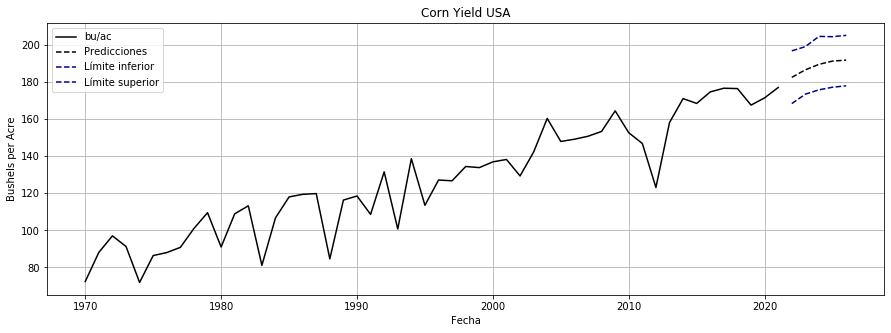

In [2]:
cornYield = pd.read_csv("Data/CornYieldUSA.csv")[["Year", "Value"]][::-1].set_index(["Year"])
predictions = TimeSeriesPrediction(cornYield[cornYield.index >= 1970], "Corn Yield USA", "bu/ac", "Fecha", 
                                   "Bushels per Acre", ["k", "darkblue"], 5)
predictions.columns = ["Predicciones (Bushels per Acre)", "Límite inferior", "Límite superior"]
predictions

In [3]:
acres = 510
harvestPred = acres * np.round(predictions)
harvestPred.columns = ["Bushels totales", "Límite inferior", "Límite superior"]
harvestPred

,Bushels totales,Límite inferior,Límite superior
2022,92820.00,85680.00,100470.00
2023,95370.00,88230.00,101490.00
2024,96390.00,89760.00,104550.00
2025,97410.00,90270.00,104040.00
2026,97920.00,90780.00,104550.00


+ Como habíamos mencionado nuestro cliente es un granjero estadounidense que busca contratar opciones del tipo put para asegurar el precio al que venderá la cosecha de maíz del año entrante. En este caso nuestro cliente posee $510$ acres (el acre es una medida de superficie usada en la agricultura, que equivale entre $0.40$ y $0.5$ héctareas), aproximadamente $204$ hectáreas de cultivo. Sin embargo, éste desconoce la producción del año entrante. Es por esto que tomamos la serie temporal conocida como `Corn Yield` de los Estados Unidos, donde se nos muestran los históricos de bushels de maíz obtenidos por acre desde la década de los $70's$. Con esta serie temporal hacemos pronósticos con ayuda de la librería `Prophet` de Facebook y llegamos a que la producción media en los Estados Unidos para el año entrante, es decir, el $2022$, será de $182.45$ bushels por cada acre de cultivo. También tenemos límites inferiores y superiores para cada pronóstico, aunque tomaremos el pronóstico medio de $182$ fanegas por acre, lo que conlleva a que nuestro cliente cosechará (entre los meses de septiembre y noviembre del año entrante) un total de $92,820$ bushels. El calculo se elabora como se muestra a continuación:

$$ \frac{182 \space bushels}{acre} * 510 \space acres = 92,820 \space bushels $$


Último precio de cotización: 585.0


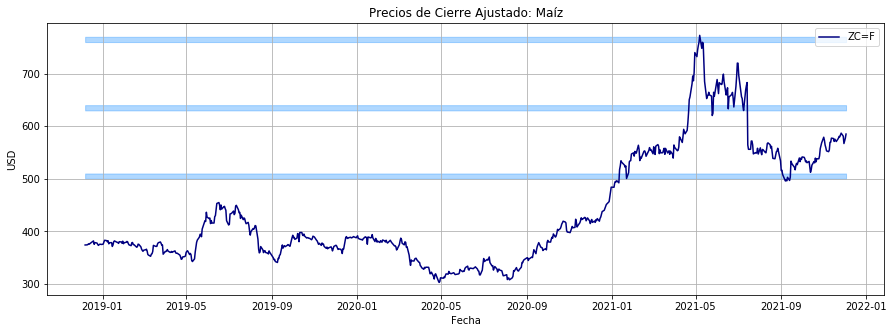

In [4]:
ticker1 = "ZC=F"
data1 = commoditiesPricesYfinance(ticker1)
data1 = commoditiesPricesVisualization(data1, "Maíz", ticker1, ["navy", "dodgerblue"], [500, 630, 760], [510, 640, 770])
print("Último precio de cotización: " + str(data1["Adj Close"].iloc[-1]))

+ Podemos observar la serie temporal del precio de cierre ajustado (en dólares) para el commodity maíz. A manera de agregado se grafican algunos niveles de soportes y resistencias que ha tenido el precio. Podemos observar que la cotización actual es de $585 \space USD$. En el peor de los escenarios, si se desploma el precio, este caería al nivel de soporte que se encuentra alrededor de los $500 \space USD$. En el mejor de los escenarios el precio puede llegar a la resistencia situada entre los $630 \space USD$ y, si tiene suficiente volumen, podría romperla para tocar el máximo histórico de mediados del presente año.

+ Los contratos recomendados al granjero (opciones del tipo put, parte larga) están pensados como protección ante un posible desplome del precio. Si resulta ser este el caso (donde $K > S_T$) dichas opciones se ejercerían con un beneficio. De lo contrario se perderían las primas (cuando $K < S_T$) y los bushels de maíz se venderían a precio de mercado. 

+ El precio de ejercicio que se define es de $K = 560 \space USD$. Se decide por este precio para que la opción se encuentre `out the money` y se puedan abaratar sus costos. Además, este precio es adecuado, pues si consideramos el peor de los escenarios, donde el precio cae al nivel de soporte de los $500 \space USD$, aún queda gran margen para ejercer la opción con beneficios.

+ Por otra parte, la barrera (para el Put Up and Out) que se define es de $B = 630 \space USD $. Se decide por este precio porque es mayor a la cotización actual (requisito para cualquier opción Put Up and Out) y, además, es aquí donde se encuentra la resistencia más cercana, la cual, sin el suficiente volumen, será difícil de romper, aunque si lo hace la opción se desactivará.

+ La fecha de vencimiento de los contratos es: $2022-12-31$.

+ Como bien sabemos existen una gran variedad de opciones (europeas, asiáticas y barrera). Nuestro objetivo es adqurir aquella que tenga la mejor relación costo-beneficio. Es por esto que a continuación se elabora la valuación de tales contratos.


In [5]:
rf = 0.26 / 100 / 252
K1, B1 = 560, 630
valuation1 = valuation(data1["Adj Close"], K1, B1, "2022-12-31", rf, 10000, 100, "Put")
valuation1

,Prima,Límite inferior,Límite superior
Put B&S,55.63,55.63,55.63
Put Europeo,45.83,40.96,50.70
Put Asiático R.,27.44,22.84,32.03
Put Asiático T.,27.43,22.83,32.03
Put Up and Out,26.20,21.33,31.07


+ Claramente la opción más barata es el `Put Up and Out`, con una prima de aproximadamente $26 \space USD$. **Recomendamos al granjero la adquisición de esta opción barrera**, pues es la más asequible en términos monetarios. Aclaramos que la opción puede desactivarse si pasa la barrera de los $630 \space USD$, lo cual es poco probable pero, en dado caso, se perderían únicamente las primas (que son las más baratas de entre todas) y los bushels de maíz se venderían al precio de mercado (mayor al pactado por el contrato), lo cual hace bastante sentido, sobre todo si consideramos que se busca pactar el precio de venta del cultivo en caso de una caída significativa de la cotización.

### Análisis de escenarios

In [6]:
cols = ["ST", "# contratos", "Primas", "Ingreso (con cobertura)", "Ingreso neto (con cobertura)", 
        "Ingreso (sin cobertura)", "Costo de oportunidad"]
ST1 = [400, 450, 500, 550, 600, 630, 650, 700, 750]
results1 = [simulation(harvestPred.loc[2022, "Bushels totales"], 5000, K1, i, valuation1.loc["Put Up and Out", "Prima"], "Put") 
             for i in ST1]
results1DF = pd.DataFrame(results1, columns = cols).set_index(["ST"])
cols.remove("ST")
results1DF["ST > B"] = np.array(ST1) > B1
results1DF["K > ST"] = K1 > np.array(ST1)
results1DF["¿Se ejerce la opción?"] = [True if (i == False) & (j == True) else False 
                for i, j in zip(results1DF["ST > B"], results1DF["K > ST"])]

results1DF[["ST > B", "K > ST", "¿Se ejerce la opción?"] + cols]

,ST > B,K > ST,¿Se ejerce la opción?,# contratos,Primas,Ingreso (con cobertura),Ingreso neto (con cobertura),Ingreso (sin cobertura),Costo de oportunidad
ST,,,,,,,,,
$400.00,False,True,True,18.00,"$2,357,964.97","$51,528,000.00","$49,170,035.03","$37,128,000.00","$-12,042,035.03"
$450.00,False,True,True,18.00,"$2,357,964.97","$51,669,000.00","$49,311,035.03","$41,769,000.00","$-7,542,035.03"
$500.00,False,True,True,18.00,"$2,357,964.97","$51,810,000.00","$49,452,035.03","$46,410,000.00","$-3,042,035.03"
$550.00,False,True,True,18.00,"$2,357,964.97","$51,951,000.00","$49,593,035.03","$51,051,000.00","$1,457,964.97"
$600.00,False,False,False,18.00,"$2,357,964.97","$52,092,000.00","$53,334,035.03","$55,692,000.00","$2,357,964.97"
$630.00,False,False,False,18.00,"$2,357,964.97","$52,176,600.00","$56,118,635.03","$58,476,600.00","$2,357,964.97"
$650.00,True,False,False,18.00,"$2,357,964.97","$52,233,000.00","$57,975,035.03","$60,333,000.00","$2,357,964.97"
$700.00,True,False,False,18.00,"$2,357,964.97","$52,374,000.00","$62,616,035.03","$64,974,000.00","$2,357,964.97"
$750.00,True,False,False,18.00,"$2,357,964.97","$52,515,000.00","$67,257,035.03","$69,615,000.00","$2,357,964.97"


+ En términos generales podemos decir que **siempre resulta favorable para el granjero el optar por la cobertura**. Ya que **cuando el precio se desploma bastante puede apreciarse que el costo de oportunidad de no optar por los contratos financieros resulta muy alto**, pues sus ingresos se hacen significativamente más pequeños a comparación de los ingresos que obtiene cuando hace la cobertura. Por otra parte, **podemos comprobar que si los contratos no se ejercen el costo de oportunidad de no usarlos es simplemente la prima que se pagó por tales instrumentos**, es decir, **si las opciones expiran sin valor lo único que el granjero pierde es el dinero que pagó por éstas**, pero recalcando que estará cubierto ante cualquier eventualidad perjudicial para sus ingresos, pues recordemos que de antemano pacta un precio de venta para su cultivo. 

In [7]:
netIncome_Option, netIncome_NoOption = netIncomeSimulation(0, 20000000, 
 ["AT", "# contratos", "Primas", "Ingreso (con cobertura)", "Ingreso neto (con cobertura)", "Ingreso (sin cobertura)", 
  "Costo de oportunidad"], harvestPred.loc[2022, "Bushels totales"], 5000, K1, 
    np.random.uniform(400, 800, 10000), valuation1.loc["Put Up and Out", "Prima"], "Put")

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,36286242.26,36092025.37,36480459.15


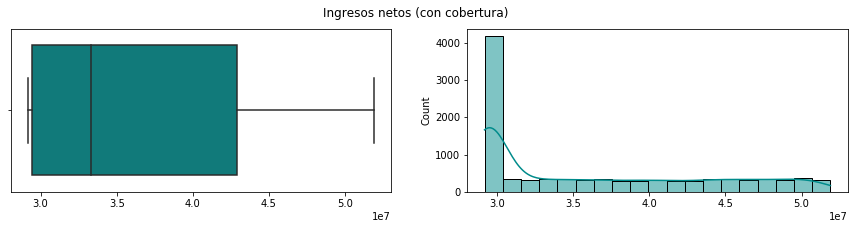

In [8]:
boxAndHistPlot(netIncome_Option, (15, 3), "darkcyan", "Ingresos netos (con cobertura)")
confidenceInterval(netIncome_Option, 0.99)

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,35821840.74,35545659.84,36098021.64


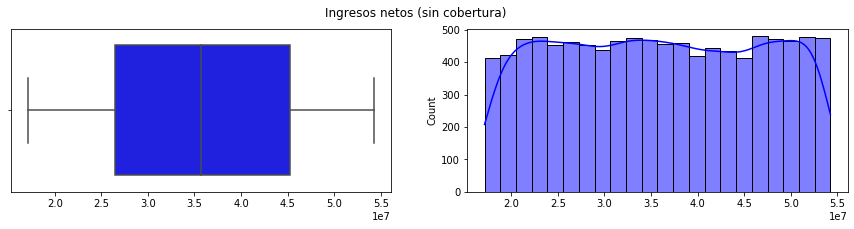

In [9]:
boxAndHistPlot(netIncome_NoOption, (15, 3), "blue", "Ingresos netos (sin cobertura)")
confidenceInterval(netIncome_NoOption, 0.99)

In [10]:
'${:,.2f}'.format(netIncome_Option.min() - netIncome_NoOption.min())

'$12,037,268.76'

+ Se elabora una simulación de los ingresos netos del granjero, sustrayendo las erogaciones a los ingresos de la venta del cultivo de maíz, en ambos casos: con y sin cobertura. Claramente **los ingresos netos cuando no se opta por la cobertura no están topados por un límite inferior, pues a medida que el precio cae la pérdida se irá agrandando**, pues el granjero tendrá que vender sus canastas de maíz a un precio bajo. **En cambio, si el granjero opta por la cobertura un desplome de la cotización no le afecta, pues ya se pactó un precio de venta de los cultivos**, por lo que podemos afirmar que en este caso los ingresos netos sí están topados por un límite inferior, es decir, no pueden caer de cierto nivel, ya que ante cualquier eventualidad negativa se hace uso de los contratos al precio de ejercicio firmado.


## Cliente 2 

> La segunda empresa, es una empresa que construye productos en aluminio que tiene 1 año de estar ejerciendo en este tipo mercado. El gerente desea crear un plan de acción para expandir la empresa realizando estrategias financieras que le permitan maximizar sus ganancias y de esta forma cumplir con el objetivo planteado.

### Recomendación

En este caso **tenemos a una empresa que manufactura productos de aluminio**. Es evidente que este insumo clave se encuentra sujeto a amplias volatilidades y su precio de adquisición puede verse abaratado o encarecido por diversas condiciones macroeconómicas, por lo que se recomienda optar por una **posición larga en una opción del tipo call**, la cual le permitirá a la empresa comprar el aluminio que necesite a un precio pactado en un tiempo futuro. A través de este mecanismo los oficiales y gerentes a cargo de la empresa pueden hacer una mejor planeación de su presupuesto: pues el precio que se pagará por el metal se conoce de antemano y una alza considerable en el mismo no presenta una amenaza. 

### Supuestos

1. La demanda y oferta del aluminio están sujetas a distintas condiciones macroeconómicas, por lo que suponemos que las operaciones usuales de la empresa requieren de la adquisición del $0.0005\%$ de la producción total de aluminio en China. 
2. Se contrata la opción financiera para protegerse en caso de una alza considerable en el precio del aluminio. Suponemos que la empresa ya tiene cubierto el inventario del primer trimestre del año entrante, por lo que las opciones se contratan con vencimiento a principios de marzo del $2022$ para cubrir el inventario del segundo trimestre.
3. Los ingresos de la empresa son por $300,000 \space USD$.
4. Cada contrato u opción se firma por $25$ metric tons ($25$ toneladas, o $25,000$ kilogramos). Esto según los contratos estandarizados del CME (Chicago Mercantile Exchange).
5. Se descargan los precios del símbolo de cotización **ALI=F**, el cual corresponde al futuro del aluminio.

### Referencias consultadas

+ https://international-aluminium.org/statistics/primary-aluminium-production/
+ https://www.cmegroup.com/markets/metals/base/aluminum.html

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


,Predicciones (miles de toneladas de aluminio),Límite inferior,Límite superior
2022,41866.85,39550.39,44243.84
2023,46345.60,44056.01,48623.61
2024,52764.53,50413.23,55080.13
2025,60944.55,58818.00,63157.15


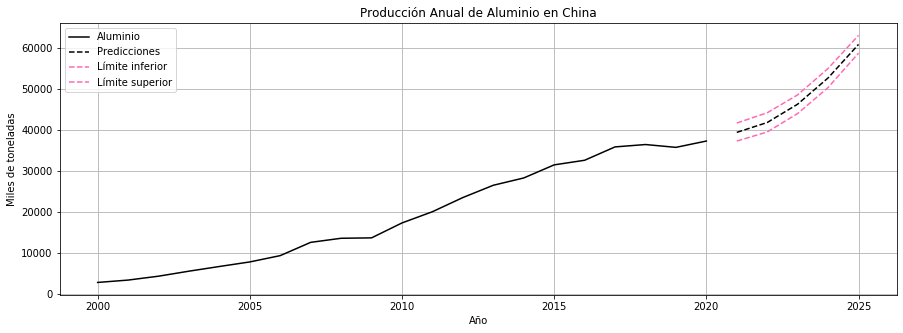

In [2]:
chinaAluminiumProd = pd.read_excel("Data/AluminioChino.xlsx").set_index(["Date"])
predictions = TimeSeriesPrediction(chinaAluminiumProd, "Producción Anual de Aluminio en China", "Aluminio", "Año", 
                                   "Miles de toneladas", ["k", "hotpink"], 5)
predictions.columns = ["Predicciones (miles de toneladas de aluminio)", "Límite inferior", "Límite superior"]
predictions.loc["2022" :, :]

In [3]:
porcentage = 0.0005 / 100
aluminiumPred = porcentage * predictions * 1000
aluminiumPred.columns = ["Toneladas de aluminio demandadas a China", "Límite inferior", "Límite superior"]
aluminiumPred.loc["2022" : , :]

,Toneladas de aluminio demandadas a China,Límite inferior,Límite superior
2022,209.33,197.75,221.22
2023,231.73,220.28,243.12
2024,263.82,252.07,275.40
2025,304.72,294.09,315.79


+ Como se había mencionado nuestro cliente es una empresa recién incorporada al mercado que manufactura productos con aluminio. En uno de nuestros supuestos establecimos que la empresa demanda cierta cantidad de la producción de aluminio total de China, por lo que, para hacernos una idea de dicha producción, se hace un pronóstico de la serie temporal que se refiere a las toneladas de aluminio producidas en China desde el año $2,000$. Una vez hechas estas predicciones con el algoritmo `Prophet` se procede a calcular la demanda estimada de la empresa, lo que arroja que el año entrante ésta importará aproximadamente $209.33$ toneladas de aluminio proveniente del gigante asiático. La empresa busca protegerse ante posibles alzas en la cotización del aluminio y compra opciones del tipo call para asegurar el precio del inventario que necesitará en el segundo trimestre del $2022$, por lo que deberá firmar aquel número de contratos que le permitan adquirir, aproximadamente, $52$ toneladas de aluminio ($209 \space / \space 4$). 

Último precio de cotización: 2596.25


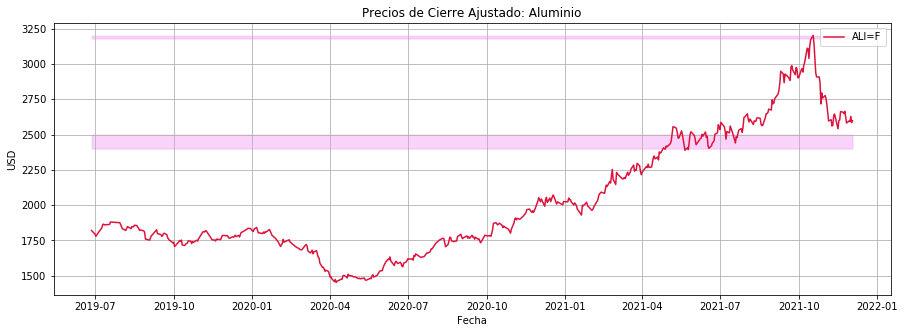

In [4]:
ticker2 = "ALI=F"
data2 = commoditiesPricesYfinance(ticker2)
data2 = commoditiesPricesVisualization(data2, "Aluminio", ticker2, ["crimson", "violet"], [2400, 3180], [2500, 3200])
print("Último precio de cotización: " + str(data2["Adj Close"].iloc[-1]))

+ Podemos observar la serie temporal del precio de cierre ajustado (en dólares) para el commodity aluminio. A manera de agregado se grafican algunos niveles de soportes y resistencias que ha tenido el precio. Podemos observar que la cotización actual es de $2,596 \space USD$. En el peor de los escenarios, si se desploma el precio, este caería al nivel de soporte que se encuentra alrededor de los $2,400 \space USD$. En el mejor de los escenarios el precio puede llegar tocar nuevamente el máximo histórico de aproximadamente $3,200 \space USD$.

+ Los contratos recomendados a la empresa (opciones del tipo call, parte larga) están pensados como protección ante una posible alza del precio. Si resulta ser este el caso (donde $S_T > K$) dichas opciones se ejercerían con un beneficio. De lo contrario se perderían las primas (cuando $S_T < K$) y las toneladas de aluminio se comprarían a precio de mercado. 

+ El precio de ejercicio que se define es de $K = 2,750 \space USD$. Se decide por este precio para que la opción se encuentre `out the money` y se puedan abaratar sus costos. Además, este precio es adecuado, pues si consideramos el peor de los escenarios, donde el precio toca o pasa el máximo histórico de $3,200 \space USD$, queda todavía gran margen para ejercer la opción con beneficios.

+ Por otra parte, la barrera (para el Call Down and Out) que se define es de $B = 2,500 \space USD $. Se decide por este precio porque es menor a la cotización actual (requisito para cualquier opción Call Down and Out) y, además, es aquí donde se encuentra el soporte más próximo, el cual, sin el suficiente volumen, será difícil de romper, aunque si lo hace la opción se desactivará.

+ La fecha de vencimiento de los contratos es: $2022-03-05$.

+ Como bien sabemos existen una gran variedad de opciones (europeas, asiáticas y barrera). Nuestro objetivo es adqurir aquella que tenga la mejor relación costo-beneficio. Es por esto que a continuación se elabora la valuación de tales contratos.

In [5]:
rf = 0.26 / 100 / 252
K2, B2 = 2750, 2500
valuation2 = valuation(data2["Adj Close"], K2, B2, "2022-03-05", rf, 10000, 100, "Call")
valuation2

,Prima,Límite inferior,Límite superior
Call B&S,51.37,51.37,51.37
Call Europeo,58.54,51.47,65.60
Call Asiático R.,14.57,7.66,21.49
Call Asiático T.,15.09,8.18,22.01
Call Down and Out,46.97,39.90,54.03


+ Claramente la opción más barata es el `Call Asiático`, con una prima de aproximadamente $14.5 \space USD$. **Recomendamos a la empresa la adquisición de esta opción asiática**, pues es la más asequible en términos monetarios. Aclaramos que la opción puede expirar sin valor, esto si $A_T < K$ (el promedio del precio del subyacente es menor al precio de ejercicio), en dado caso se perderían únicamente las primas (que son las más baratas de entre todas) y las toneladas de aluminio se comprarían al precio de mercado (menor al pactado por el contrato), lo cual hace bastante sentido, sobre todo si consideramos que lo que se busca es pactar el precio de compra del insumo en caso de una alza significativa de la cotización.

### Análisis de escenarios

In [6]:
cols = ["AT", "# contratos", "Primas", "Egreso (con cobertura)", "Egreso total (con cobertura)", 
        "Egreso (sin cobertura)", "Costo de oportunidad"]
ST2 = [2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200]
results2 = [simulation(np.round(aluminiumPred.loc[2022, "Toneladas de aluminio demandadas a China"] / 4, 2), 25, K2, i, 
                       valuation2.loc["Call Asiático R.", "Prima"], "Call") for i in ST2]
results2DF = pd.DataFrame(results2, columns = cols).set_index(["AT"])
cols.remove("AT")
results2DF["AT > K"] = np.array(ST2) > K2
results2DF["¿Se ejerce la opción?"] = [True if i == True else False for i in results2DF["AT > K"]]

results2DF[["AT > K", "¿Se ejerce la opción?"] + cols]

,AT > K,¿Se ejerce la opción?,# contratos,Primas,Egreso (con cobertura),Egreso total (con cobertura),Egreso (sin cobertura),Costo de oportunidad
AT,,,,,,,,
"$2,400.00",False,False,2.00,$728.72,"$143,092.00","$126,320.72","$125,592.00",$728.72
"$2,500.00",False,False,2.00,$728.72,"$143,325.00","$131,553.72","$130,825.00",$728.72
"$2,600.00",False,False,2.00,$728.72,"$143,558.00","$136,786.72","$136,058.00",$728.72
"$2,700.00",False,False,2.00,$728.72,"$143,791.00","$142,019.72","$141,291.00",$728.72
"$2,800.00",True,True,2.00,$728.72,"$144,024.00","$144,752.72","$146,524.00","$-1,771.28"
"$2,900.00",True,True,2.00,$728.72,"$144,257.00","$144,985.72","$151,757.00","$-6,771.28"
"$3,000.00",True,True,2.00,$728.72,"$144,490.00","$145,218.72","$156,990.00","$-11,771.28"
"$3,100.00",True,True,2.00,$728.72,"$144,723.00","$145,451.72","$162,223.00","$-16,771.28"
"$3,200.00",True,True,2.00,$728.72,"$144,956.00","$145,684.72","$167,456.00","$-21,771.28"


In [7]:
netIncome_Option, netIncome_NoOption = netIncomeSimulation(300000, 0, 
 ["AT", "# contratos", "Primas", "Egreso (con cobertura)", "Egreso total (con cobertura)", "Egreso (sin cobertura)", 
  "Costo de oportunidad"], np.round(aluminiumPred.loc[2022, "Toneladas de aluminio demandadas a China"] / 4, 2), 25, K2, 
    np.random.uniform(2000, 3500, 10000), valuation2.loc["Call Asiático R.", "Prima"], "Call")

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,164524.20,164191.44,164856.95


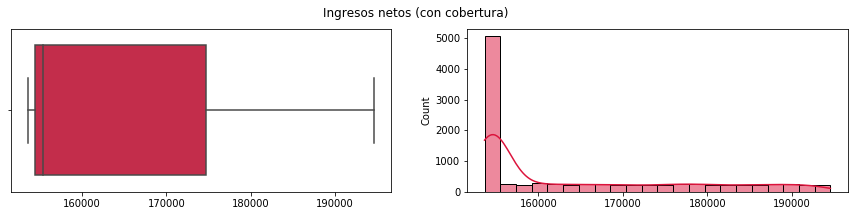

In [8]:
boxAndHistPlot(netIncome_Option, (15, 3), "crimson", "Ingresos netos (con cobertura)")
confidenceInterval(netIncome_Option, 0.99)

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,155705.92,155121.56,156290.29


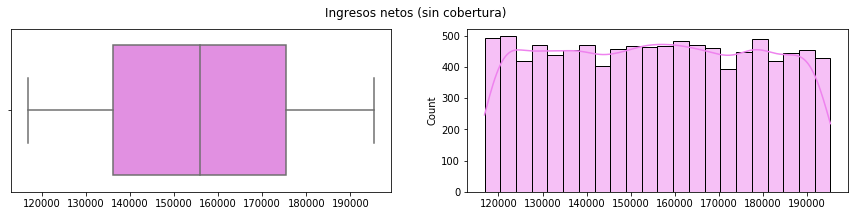

In [9]:
boxAndHistPlot(netIncome_NoOption, (15, 3), "violet", "Ingresos netos (sin cobertura)")
confidenceInterval(netIncome_NoOption, 0.99)

In [10]:
'${:,.2f}'.format(netIncome_Option.min() - netIncome_NoOption.min())

'$36,770.87'

+ D

## Cliente 3

> El tercer cliente, es una empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.

### Recomendación


### Supuestos


### Referencias consultadas

+ http://www.idexonline.com/FullArticle?Id=36728

Último precio de cotización: 1785.5


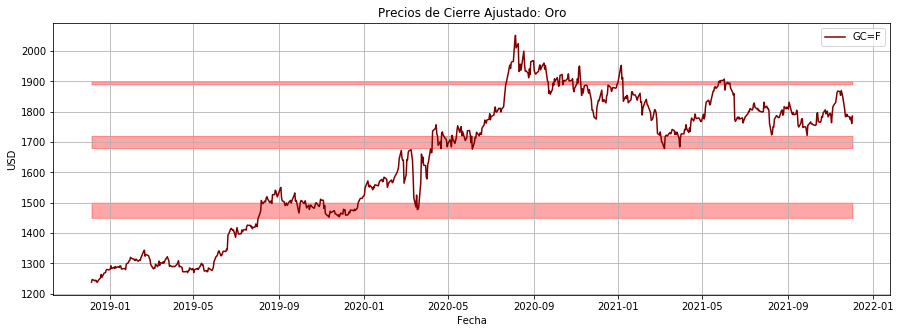

In [7]:
ticker3 = "GC=F"
data3 = commoditiesPricesYfinance(ticker3)
data3 = commoditiesPricesVisualization(data3, "Oro", ticker3, ["maroon", "red"], [1680, 1450, 1890], [1720, 1500, 1900])
print("Último precio de cotización: " + str(data3["Adj Close"].iloc[-1]))

## Cliente 4

> Nuestro último cliente, es la empresa mexicana PEMEX, que desea ejecutar ciertas estrategias financieras, que les permita cubrirse ante posibles caídas en el precio del barril del petróleo. Su objetivo en maximizar sus ganancias y minimizar las pérdidas de la compañía usando la mejor estrategia financiera (costo-beneficio).

### Recomendación

En este último caso **tenemos a la empresa mexicana PEMEX que desea protegerse ante las fluctuaciones del precio del crudo para asegurar sus ingresos de la producción de petróleo**. Es lógico que PEMEX busca vender sus barriles de crudo a un precio pactado, por lo que **le recomendamos una posición larga en una opción del tipo put**, la cual le permitirá vender sus barriles de petróleo a un precio determinado en un tiempo futuro. Con esto los directores y oficiales al mando de PEMEX podrán estar tranquilos ante posibles caídas en el precio del crudo, pues contratan una opción donde se pacta un precio de venta para su producción. Es importante hacerle notar a PEMEX que este contrato financiero presenta un costo, lo que se conoce como la prima, por lo que, en dado caso que no se ejerza, se perderá tal prima.

### Supuestos

1. Se contrata la opción financiera para asegurar el precio de venta de la producción de barriles de crudo del primer trimestre del año entrante (el vencimiento de la opción es a principios de abril del $2022$).
2. PEMEX desconoce la producción de barriles del primer trimestre del año entrante.
3. Los egresos de PEMEX son por $7,000,000,000 \space USD$
4. Cada contrato u opción se firma por $1,000$ barriles de crudo. Esto según los contratos estandarizados del CME (Chicago Mercantile Exchange).
5. Se decargan los precios del símbolo de cotización **CL=F**, el cual corresponde al futuro de petróleo crudo WTI.

### Referencias consultadas

+ https://es.statista.com/estadisticas/612012/exportaciones-anuales-de-petroleo-crudo-de-petroleos-mexicanos/
+ https://datosmacro.expansion.com/energia-y-medio-ambiente/petroleo/produccion/mexico?anio=2020
+ https://www.cmegroup.com/markets/energy/crude-oil/light-sweet-crude.html

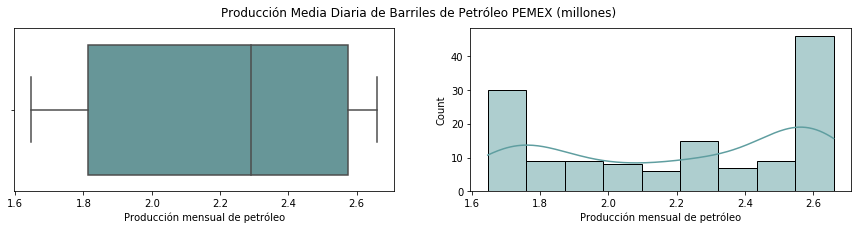

In [2]:
oilBarrelsPEMEX = pd.read_excel("Data/PEMEXProduccionPetroleo.xlsx").set_index(["Fecha"])[::-1]
boxAndHistPlot(oilBarrelsPEMEX["Producción mensual de petróleo"], (15, 3), "cadetblue", 
               "Producción Media Diaria de Barriles de Petróleo PEMEX (millones)")

+ Es bien sabido que la producción media diaria de barriles de crudo por parte de PEMEX es un tanto errática. Es por esto que ajustaremos una serie de distribuciones hipotéticas a los datos históricos (que van desde el $2010$ hasta julio del presente año) de la producción de petróleo de la empresa mexicana para generar variables aleatorias con ayuda de Montecarlo y encontrar el valor esperado de tales muestras, es decir, la producción media diaria de barriles por parte de Petróleos Mexicanos. Con esto nos daremos una idea de los barriles totales que se producirán en el primer trimestre del año entrante y podremos saber cuántas opciones financieras se contratarán (recordemos que uno de los supuestos es que PEMEX desconoce la producción para el primer trimestre del año entrante).

,MSE
johnsonsb,0.54
levy_l,0.71
tukeylambda,0.82
genextreme,0.84
frechet_l,0.84


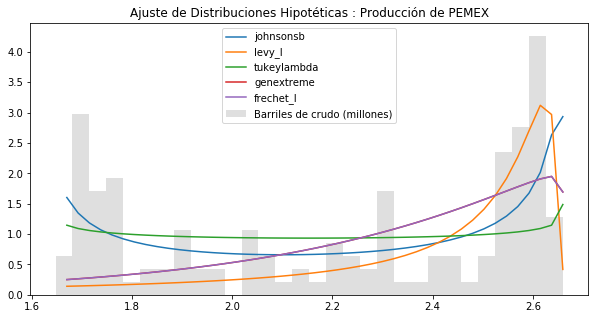

In [3]:
oilBarrelsPEMEX = oilBarrelsPEMEX["Producción mensual de petróleo"]
fitting = fittingHypotheticalDistributions(oilBarrelsPEMEX, "MSE", "Barriles de crudo (millones)", "gray", 
                                            "Ajuste de Distribuciones Hipotéticas : Producción de PEMEX", (10, 5))
fitting

+ De las distribuciones hipotéticas que se encuentran disponibles en la paquetería `stats` tenemos que las que presentan menor error de ajuste son: *johnsonsb, levy_l, tukeylambda, genextreme, frechet_l*. Sin embargo, la mayoría, a excepción de *johnsonsb*, no parecen capturar la forma de la distribución de los datos. A continuación se muestran las pruebas visuales y estadísticas para concluir de manera más certera si tales distribuciones tienen o no un buen ajuste.

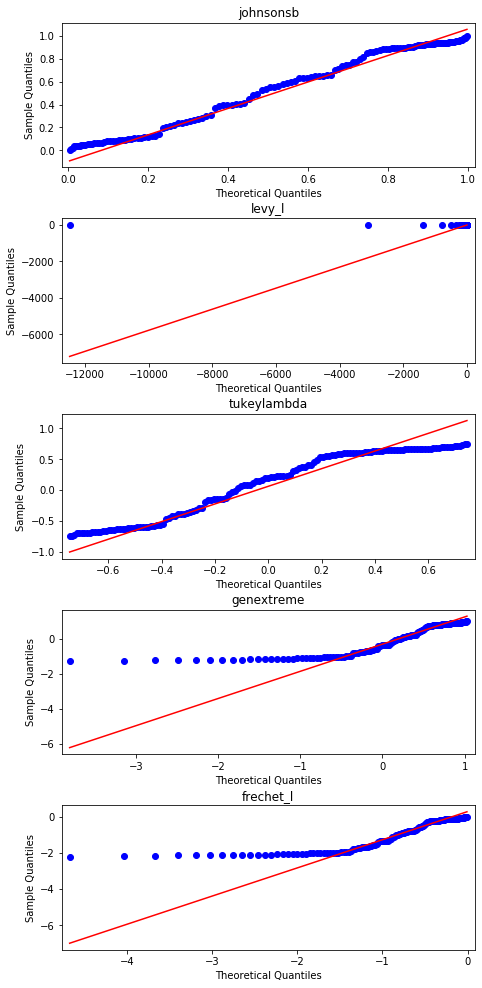

In [4]:
qqPlot(oilBarrelsPEMEX, fitting, (7, 14))

+ Por el gráfico Q-Q (cuantil-cuantil) concluimos que, en efecto, los datos de la producción media diaria de barriles de crudo parecen venir de la distribución *johnsonsb*, pues la línea azul sigue de cerca a la línea de $45º$.

In [5]:
chiSquared_KolmogorovSmirnov(oilBarrelsPEMEX, fitting)

,Valor P Prueba Chi-Cuadrada,Interpretación (1),Valor P Prueba Kolmogorov-Smirnov,Interpretación (2)
johnsonsb,0.54,No se rechaza la hipótesis nula,0.07,No se rechaza la hipótesis nula
levy_l,0.00,Se rechaza la hipótesis nula,0.00,Se rechaza la hipótesis nula
tukeylambda,0.37,No se rechaza la hipótesis nula,0.00,Se rechaza la hipótesis nula
genextreme,0.01,Se rechaza la hipótesis nula,0.01,Se rechaza la hipótesis nula
frechet_l,0.01,Se rechaza la hipótesis nula,0.01,Se rechaza la hipótesis nula


+ Finalmente, con las pruebas de hipótesis de la Chi-Cuadrada y Kolmogorov-Smirnov, comprobamos que los datos pueden ser modelados por la distribución *johnsonsb*, pues, en ambos casos, no se rechaza la hipótesis nula (con un nivel de significancia del $5\%$).

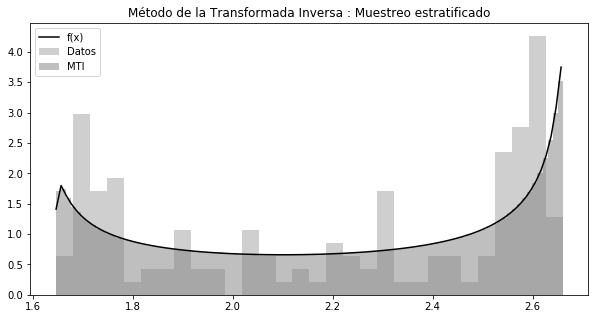

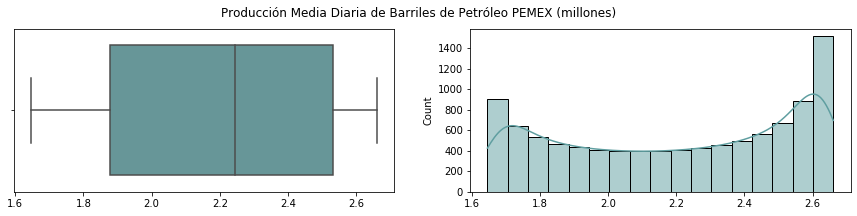

In [6]:
oilBarrels = inverseTransform(oilBarrelsPEMEX, 10000, "johnsonsb", "Muestreo estratificado", "Datos", 
                                  ["silver", "k", "grey"])

boxAndHistPlot(oilBarrels, (15, 3), "cadetblue", "Producción Media Diaria de Barriles de Petróleo PEMEX (millones)")

In [7]:
predictionsOilBarrels = confidenceInterval(oilBarrels, 0.99)
predictionsOilBarrels

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,2.20,2.19,2.21


In [8]:
period = 24 * 3
predictionsOilBarrels = period * np.round(predictionsOilBarrels, 2)
predictionsOilBarrels.columns = ["Barriles de crudo (1er trimestre)", "Límite inferior", "Límite superior"]
predictionsOilBarrels

,Barriles de crudo (1er trimestre),Límite inferior,Límite superior
Nivel de confianza : 99.0%,158.40,157.68,159.12


+ Al generar $10,000$ variables aleatorias con la distribución hipotética ajustada comprobamos, de manera visual, que las muestras generadas se aproximan bastante a los datos originales. Tales variables aleatorias representan la producción media diaria de barriles de crudo por parte de PEMEX. Además, se computa un intervalo de confianza para la media de tales muestras, lo que arroja que PEMEX, de media, produce $2.20$ millones de barriles de crudo diariamente, con sus respectivos límites inferior y superior. Como nos interesa conocer la producción para el primer trimestre del año entrante basta con multiplicar tal cantidad por los $72$ días hábiles que hay en tal período de tiempo; el cálculo matemático se muestra a continuación:

$$ \frac{2.20 \space (millones) \space de \space barriles}{día} * 72 \space días = 158.4 \space millones \space de \space barriles \space de \space crudo $$

Último precio de cotización: 67.83999633789062


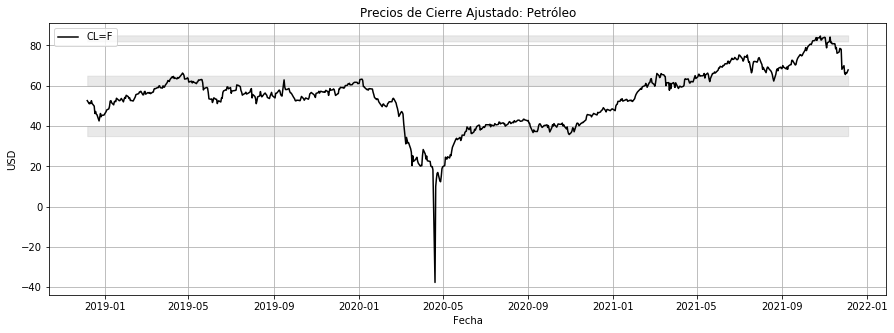

In [9]:
ticker4 = "CL=F"
data4 = commoditiesPricesYfinance(ticker4)
data4 = commoditiesPricesVisualization(data4, "Petróleo", ticker4, ["k", "silver"], [60, 35, 82], [65, 40, 85])
print("Último precio de cotización: " + str(data4["Adj Close"].iloc[-1]))

+ Podemos observar la serie temporal del precio de cierre ajustado (en dólares) para el commodity petróleo. A manera de agregado se grafican algunos niveles de soportes y resistencias que ha tenido el precio. Podemos observar que la cotización actual es de $67 \space USD$. En el peor de los escenarios, si el precio rompe (con volumen) el soporte situado alrededor del nivel de los $60 \space USD$ podría desplomarse y llegar a tocar el siguiente soporte ubicado en el nivel de los $40 \space USD$. En el mejor de los escenarios el precio puede llegar a la resistencia situada alrededor de los $80 \space USD$.

+ Los contratos recomendados a PEMEX (opciones del tipo put, parte larga) están pensados como protección ante un posible desplome del precio. Si resulta ser este el caso (donde $K > S_T$) dichas opciones se ejercerían con un beneficio. De lo contrario se perderían las primas (cuando $K < S_T$) y los barriles de petróleo crudo se venderían a precio de mercado.

+ El precio de ejercicio que se define es de $K = 60 \space USD$. Se decide por este precio para que la opción se encuentre `out of the money` y se puedan abaratar sus costos. Además, este precio es adecuado, pues si consideramos el peor de los escenarios, donde el precio cae al nivel de soporte de los $40 \space USD$, aún queda gran margen para ejercer la opción con beneficios.

+ Por otra parte, la barrera (para el Put Up and Out) que se define es de $B = 80 \space USD$. Se decide por este precio porque es mayor a la cotización actual (requisito para cualquier opción Put Up and Out) y, además, es aquí donde se encuentra la resistencia más cercana, la cual, sin el suficiente volumen, será difícil de romper, aunque si lo hace la opción se desactivará.

+ La fecha de vencimiento de los contratos es: $2022-04-01$.

+ Como bien sabemos existen una gran variedad de opciones (europeas, asiáticas y barrera). Nuestro objetivo es adquirir aquella que tenga la mejor relación costo-beneficio. Es por esto que a continuación se elabora la valuación de tales contratos.

In [10]:
rf = 0.27 / 100 / 252
K4, B4 = 60, 80
valuation4 = valuation(data4["Adj Close"], K4, B4, "2022-04-01", rf, 10000, 100, "Put")
valuation4

,Prima,Límite inferior,Límite superior
Put B&S,5.62,5.62,5.62
Put Europeo,4.56,3.87,5.24
Put Asiático R.,2.13,1.49,2.78
Put Asiático T.,2.19,1.55,2.84
Put Up and Out,3.85,3.16,4.53


+ Claramente la opción más barata es el `Put Asiático`, con una prima de aproximadamente $2.1 \space USD$. **Recomendamos a PEMEX la adquisición de esta opción asiática**, pues es la más asequible en términos monetarios. Aclaramos que la opción puede expirar sin valor, esto si $A_T > K$ (el promedio del precio del subyacente es mayor al precio de ejercicio), en dado caso se perderían únicamente las primas (que son las más baratas de entre todas) y los barriles de petróleo se venderían al precio de mercado (mayor al pactado por el contrato), lo cual hace bastante sentido, sobre todo si consideramos que se busca pactar el precio de venta de la producción de crudo en caso de una caída significativa de la cotización.

### Análisis de escenarios

In [11]:
cols = ["AT", "# contratos", "Primas", "Ingreso (con cobertura)", "Ingreso neto (con cobertura)", 
        "Ingreso (sin cobertura)", "Costo de oportunidad"]
ST4 = [40, 45, 50, 55, 65, 70, 75, 80, 85]
results4 = [simulation(predictionsOilBarrels.iloc[0, 0] * 1000000, 1000, K4, i, 
                       valuation4.loc["Put Asiático R.", "Prima"], "Put") for i in ST4]
results4DF = pd.DataFrame(results4, columns = cols).set_index(["AT"])
cols.remove("AT")
results4DF["K > AT"] = K4 > np.array(ST4)
results4DF["¿Se ejerce la opción?"] = [True if i == True else False for i in results4DF["K > AT"]]

results4DF[["K > AT", "¿Se ejerce la opción?"] + cols]

,K > AT,¿Se ejerce la opción?,# contratos,Primas,Ingreso (con cobertura),Ingreso neto (con cobertura),Ingreso (sin cobertura),Costo de oportunidad
AT,,,,,,,,
$40.00,True,True,158400.00,"$337,955,538.68","$9,504,000,000.00","$9,166,044,461.32","$6,336,000,000.00","$-2,830,044,461.32"
$45.00,True,True,158400.00,"$337,955,538.68","$9,504,000,000.00","$9,166,044,461.32","$7,128,000,000.00","$-2,038,044,461.32"
$50.00,True,True,158400.00,"$337,955,538.68","$9,504,000,000.00","$9,166,044,461.32","$7,920,000,000.00","$-1,246,044,461.32"
$55.00,True,True,158400.00,"$337,955,538.68","$9,504,000,000.00","$9,166,044,461.32","$8,712,000,000.00","$-454,044,461.32"
$65.00,False,False,158400.00,"$337,955,538.68","$9,504,000,000.00","$9,958,044,461.32","$10,296,000,000.00","$337,955,538.68"
$70.00,False,False,158400.00,"$337,955,538.68","$9,504,000,000.00","$10,750,044,461.32","$11,088,000,000.00","$337,955,538.68"
$75.00,False,False,158400.00,"$337,955,538.68","$9,504,000,000.00","$11,542,044,461.32","$11,880,000,000.00","$337,955,538.68"
$80.00,False,False,158400.00,"$337,955,538.68","$9,504,000,000.00","$12,334,044,461.32","$12,672,000,000.00","$337,955,538.68"
$85.00,False,False,158400.00,"$337,955,538.68","$9,504,000,000.00","$13,126,044,461.32","$13,464,000,000.00","$337,955,538.68"


+ En términos generales podemos decir que **siempre resulta favorable para PEMEX el optar por la cobertura**. Ya que **cuando el precio se desploma bastante puede apreciarse que el costo de oportunidad de no optar por los contratos financieros resulta muy alto**, pues sus ingresos se hacen significativamente más pequeños a comparación de los ingresos que obtiene cuando hace la cobertura. Por otra parte, **podemos comprobar que si los contratos no se ejercen el costo de oportunidad de no usarlos es simplemente la prima que se pagó por tales instrumentos**, es decir, **si las opciones expiran sin valor lo único que PEMEX pierde es el dinero que pagó por éstas**, pero recalcando que estará cubierta ante cualquier eventualidad perjudicial para sus ingresos, pues recordemos que de antemano pacta un precio de venta para su producción de crudo. 

In [12]:
netIncome_Option, netIncome_NoOption = netIncomeSimulation(0, 7000000000, 
 ["AT", "# contratos", "Primas", "Ingreso (con cobertura)", "Ingreso neto (con cobertura)", "Ingreso (sin cobertura)", 
  "Costo de oportunidad"], predictionsOilBarrels.iloc[0, 0] * 1000000, 1000, K4, 
    np.random.uniform(40, 85, 10000), valuation4.loc["Put Asiático R.", "Prima"], "Put")

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,3275815134.50,3242104326.03,3309525942.98


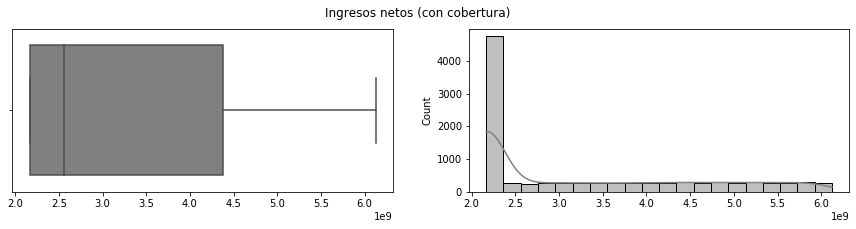

In [13]:
boxAndHistPlot(netIncome_Option, (15, 3), "grey", "Ingresos netos (con cobertura)")
confidenceInterval(netIncome_Option, 0.99)

,Media,Límite inferior,Límite superior
Nivel de confianza : 99.0%,2915864229.28,2862865591.23,2968862867.33


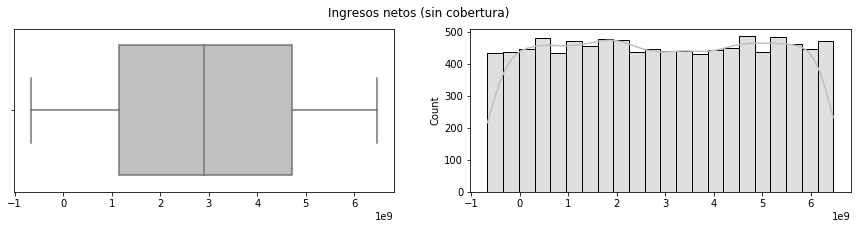

In [14]:
boxAndHistPlot(netIncome_NoOption, (15, 3), "silver", "Ingresos netos (sin cobertura)")
confidenceInterval(netIncome_NoOption, 0.99)

In [15]:
'${:,.2f}'.format(netIncome_Option.min() - netIncome_NoOption.min())

'$2,829,169,438.90'

+ Se elabora una simulación de los ingresos netos de PEMEX, sustrayendo las erogaciones a los ingresos de la venta de la producción de crudo, en ambos casos: con y sin cobertura. Claramente **los ingresos netos cuando no se opta por la cobertura no están topados por un límite inferior, pues a medida que el precio cae la pérdida se irá agrandando**, pues PEMEX tendrá que vender sus barriles de petróleo a un precio bajo. **En cambio, si Petróleos Mexicanos opta por la cobertura un desplome de la cotización no le afecta, pues ya se pactó un precio de venta de los barriles de crudo**, por lo que podemos afirmar que en este caso los ingresos netos sí están topados por un límite inferior, es decir, no pueden caer de cierto nivel, ya que ante cualquier eventualidad negativa se hace uso de los contratos al precio de ejercicio firmado.


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>